## Probabilistic Programming 3: Assignment

In this assignment, we will be using a regression model for forecasting. You will need to compute the posterior predictive distribution and visualize the estimates. If this doesn't ring a bell, have another look at the lecture on [regression](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Regression.ipynb).

In [ ]:
using Pkg
Pkg.activate("workspace/")
Pkg.instantiate();

In [ ]:
using Random
using ForneyLab
using Plots

In [ ]:
Random.seed!(250) # Do not change this!

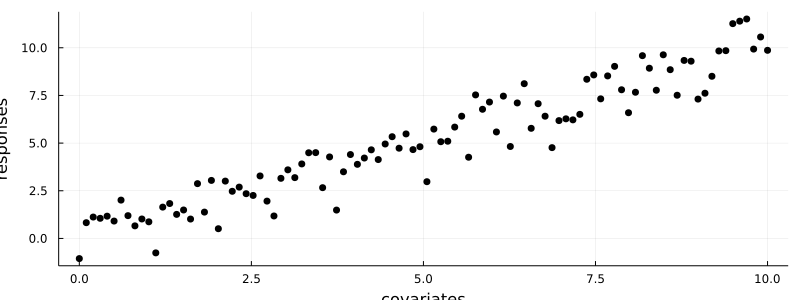

In [3]:
# Generate data
sample_size = 100
covariates = collect(range(0., stop=10., length=sample_size))
responses = covariates .+ randn(sample_size,)

# Visualize data
scatter(covariates, responses, color="black", label="", xlabel="covariates", ylabel="responses", size=(800,300))

In [4]:
# Start factor graph
g = FactorGraph();

# Variance of likelihood
σ2_Y = 1.

# Covariates
@RV X; placeholder(X, :X, dims=(2,))

# Define a prior over the weights
@RV θ ~ GaussianMeanVariance([0.0, 0.0], [1.0 0.;0. 1.0])

# Regressors
@RV Y ~ GaussianMeanVariance(dot(X,θ), σ2_Y)
placeholder(Y, :Y)

# Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ, free_energy=true) 
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

# Visualise the graph
ForneyLab.draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.43.0 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2088525008800088899 -->
 
 2088525008800088899 
 
 placeholder_X 
 
<!-- 15562447168593047486 -->
 
 15562447168593047486 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 18392533226021697013 -->
 
 18392533226021697013 
 
 clamp_3 
 
<!-- 15562447168593047486--18392533226021697013 -->
 
 15562447168593047486--18392533226021697013 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 6360355698299818812 -->
 
 6360355698299818812 
 
 dot 
 dotproduct_1 
 
<!-- 15562447168593047486--6360355698299818812 -->
 
 15562447168593047486--6360355698299818812 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 17040066758765602249 -->
 
 17040066758765602249 
 
 clamp_2 
 
<!-- 4659577749219416710 -->
 
 4659577749219416710 
 
 clamp_1 
 
<!-- 6360355698299818812--2088525008800088899 -->
 
 6360355698299818812--2088525008800088899 
 
 X 
 1 out 
 3 in2 
 
<!-- 5505342365651063367 -->
 
 5505342365651063367 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 6360355698299818812--5505342365651063367 -->
 
 6360355698299818812--5505342365651063367 
 
 θ 
 1 out 
 2 in1 
 
<!-- 5505342365651063367--17040066758765602249 -->
 
 5505342365651063367--17040066758765602249 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 5505342365651063367--4659577749219416710 -->
 
 5505342365651063367--4659577749219416710 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 9064335120618992713 -->
 
 9064335120618992713 
 
 placeholder_Y 
 
<!-- 9064335120618992713--15562447168593047486 -->
 
 9064335120618992713--15562447168593047486 
 
 Y 
 1 out 
 1 out

In [5]:
# Initialize posteriors dictionary
posteriors = Dict()
for i = 1:sample_size
    
    # Load i-th data point
    data = Dict(:X => [covariates[i], 1],
                :Y => responses[i])

    # Update posterior for θ
    step!(data, posteriors)
end

# Moments of posterior distribution for regression parameters
mθ = mean(posteriors[:θ])
Vθ = cov(posteriors[:θ])
println("Mean = "*string(mθ))
println("Covariance = "*string(Vθ))

Mean = [0.9673907644614995, 0.09673907644614843]
Covariance = [0.01960784313724491 -0.09803921568617552; -0.09803921568617552 0.9901960784303824]


So, we now have a posterior distribution for the regression parameters $\theta$. Below we are generating new covariates $x_{\bullet}$ and want to infer the unknown responses $y_{\bullet}$. The predictive distribution is described in the lectures as $p(y_{\bullet} \mid x_{\bullet}, D)$ where $D$ is previously observed data. This distribution has a particular form according to our regression model described above.

### **1) Compute the mean of the predictive distribution.**

Tip: use `.*` and `.+` to multiply with or add a number to each element in an array; `3 .* [1 2 3] = [3 6 9]` and `[1 2 3] .+ 3 = [4 5 6]` (see [broadcasting](https://docs.julialang.org/en/v1/manual/arrays/#Broadcasting))

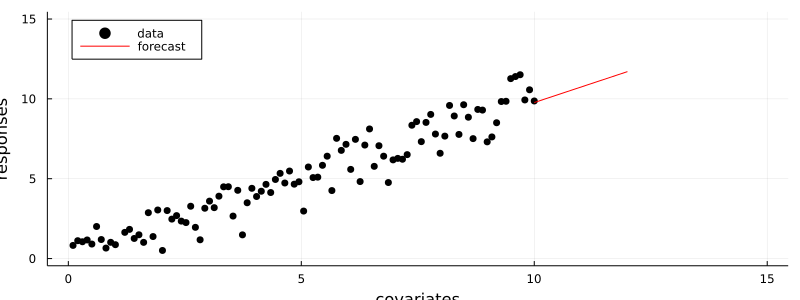

In [6]:
# Generate future covariates
num_future = 10
x_bullet = collect(range(10.0, stop=12, length=num_future))

# Create a variable "mean_y_bullet" with the mean of predictive distribution
### BEGIN SOLUTION
mean_y_bullet = mθ'*[x_bullet, ones(num_future,)]
### END SOLUTION

# Visualize forecasts
scatter(covariates, responses, color="black", label="data", xlabel="covariates", ylabel="responses", xlims=[0., 15.], ylims=[0., 15.], legend=:topleft)
plot!(x_bullet, mean_y_bullet, label="forecast", color="red", size=(800,300))

Your visualization should look this:

![](figures/mean_predictive.png)

In [7]:
# Check your answer
@assert @isdefined(mean_y_bullet)
@assert typeof(mean_y_bullet) == Array{Float64,1}
@assert size(mean_y_bullet) == (10,)
### BEGIN HIDDEN TESTS
@assert sum(abs.(mean_y_bullet .- 
[ 9.770646721061144
  9.985622446497032
 10.20059817193292
 10.415573897368809
 10.630549622804699
 10.845525348240587
 11.060501073676477
 11.275476799112365
 11.490452524548255
 11.705428249984143])) < 0.1
### END HIDDEN TESTS

### **2) Compute the variance of the predictive distribution.**

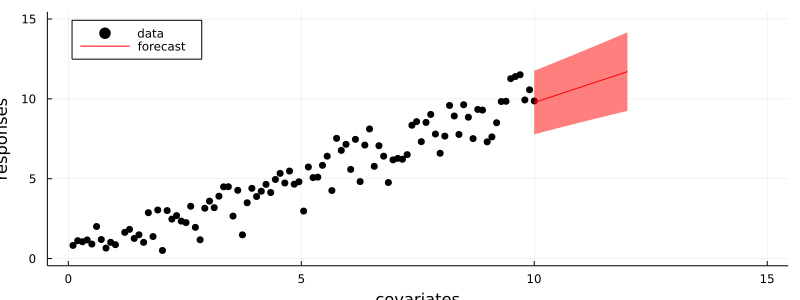

In [8]:
# Create a variable "var_y_bullet" with the variance of the predictive distribution
### BEGIN SOLUTION
var_y_bullet = [σ2_Y .+ [x_, 1]'*Vθ*[x_, 1] for x_ in x_bullet]
### END SOLUTION

# Visualize forecasts
scatter(covariates, responses, color="black", label="data", xlabel="covariates", ylabel="responses", xlims=[0., 15.], ylims=[0., 15.], legend=:topleft)
plot!(x_bullet, mean_y_bullet, ribbon=[var_y_bullet, var_y_bullet], label="forecast", color="red", size=(800,300))

Your visualization should look like this:

![](figures/full_predictive.png)

In [9]:
# Check your answer
@assert @isdefined(var_y_bullet)
@assert typeof(var_y_bullet) == Array{Float64,1}
@assert size(var_y_bullet) == (10,)
### BEGIN HIDDEN TESTS
@assert sum(abs.(var_y_bullet .- 
[1.990196078431363
 2.034737351730805
 2.0812152021302226
 2.129629629629614
 2.1799806342289814
 2.2322682159283227
 2.2864923747276396
 2.34265311062693
 2.4007504236261963
 2.460784313725437])) < 0.1
### END HIDDEN TESTS